##Tech Challenge 4 - Modelo de ML LSTM


###Instalação da biblioteca requests

In [1]:
!pip install requests

###Bibliotecas necessárias para a realização do Modelo escolhido

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import requests
from datetime import timedelta

###Código para a conexão da API do EIA e criação do Dataframe dos dados consumidos pela API

In [181]:
# URL da API
api_key ="qbdOvq5gYq6VjMNf4ynhhFWuIUdiueaNKEZM9Pk3"
url = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?frequency=daily&data[0]=value&facets[product][]=EPCBRENT&start=2006-01-01&end=2024-11-01&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"

# Fazer a requisição GET
response = requests.get(url)

# Verificar se a requisição foi bem-sucedida
if response.status_code == 200:
    data = response.json()  # Obter os dados JSON
else:
    print("Erro na requisição:", response.status_code)

df = pd.DataFrame(data['response']['data'])

df_base = df[['period','value']]
df_base = df_base.rename(columns = {'period':'Data'})
df_base = df_base.rename(columns = {'value':'Valor'})

df_base ['Data'] = pd.to_datetime(df_base['Data'],format ="%Y-%m-%d")

df_base = df_base.sort_values(by='Data', ascending=True)

###Criação de um novo dataframe com as colunas necessárias para o desenvovimento do modelo preditivo

In [182]:
db = df[['period','value']]
db = db.rename(columns = {'period':'Data'})
db = db.rename(columns = {'value':'Valor'})
db['Data'] = pd.to_datetime(db['Data'],format ="%Y-%m-%d")
db = db.sort_values(by='Data', ascending=True)


In [183]:
db_sorted = db

###Dataframe para realizar a comparação entre os dados da api com os dados previstos

In [184]:
db_comparacao = db_sorted[db_sorted['Data'] == '2024-11-01']
db_comparacao['Valor'] = pd.to_numeric(db_comparacao['Valor'])

<ipython-input-184-143f160bac2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_comparacao['Valor'] = pd.to_numeric(db_comparacao['Valor'])


In [185]:
db_sorted = db_sorted[db_sorted['Data']< '2024-11-01']

In [187]:
db = db.set_index(pd.DatetimeIndex(db['Data'].values))

In [188]:
db = db[db['Data']< '2024-11-01']

In [189]:
db = db.drop('Data',axis=1)

In [190]:
db2 = db

###Separação entre as linhas totais, linhas de treino e linhas de testes

In [191]:
qtd_linha = len(db)-1

qtd_linha_treino = round(.70 * qtd_linha)

qtd_linha_teste = qtd_linha - qtd_linha_treino

print(qtd_linha,qtd_linha_treino,qtd_linha_teste)

4763 3334 1429


###Normalizando os dados


In [192]:

scaler = StandardScaler()

df_scaler = scaler.fit_transform(db)

###Separar treino e teste


In [193]:

train = df_scaler[:qtd_linha_treino]
test = df_scaler[qtd_linha_treino:qtd_linha_treino+qtd_linha_teste]

print(len(train), len(test))

3334 1429


###Função de formatar


In [194]:

def create_df (df,steps=1):
  dataX, dataY = [],[]
  for i in range(len(df)-steps-1):
    a = df[i:(i+steps),0]
    dataX.append(a)
    dataY.append(df[i + steps,0])
  return np.array(dataX), np.array(dataY)

###Gerando dados de treino e teste


In [195]:

steps = 15
x_train, y_train = create_df(train,steps)
x_test, y_test = create_df(test,steps)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3318, 15)
(1413, 15)
(3318,)
(1413,)


###Formatando a saída

In [196]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)

x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

###Montando a rede


In [197]:
model = Sequential()
model.add(LSTM(35,return_sequences=True,input_shape=(steps,1)))
model.add(LSTM(35,return_sequences=True))
model.add(LSTM(35))
model.add(Dropout(0.2))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


###Compilando o Modelo

In [198]:

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 15, 35)              │           5,180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 15, 35)              │           9,940 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 35)                  │           9,940 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 35)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              36 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,096 (98.03 KB)

 Trainable params: 25,096 (98.03 KB)

 Non-trainable params: 0 (0.00 B)

###Treinando o Modelo

In [200]:

validation = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=15,verbose=2)

Epoch 1/100


KeyboardInterrupt: 

##Plotando a perda do treino e do teste

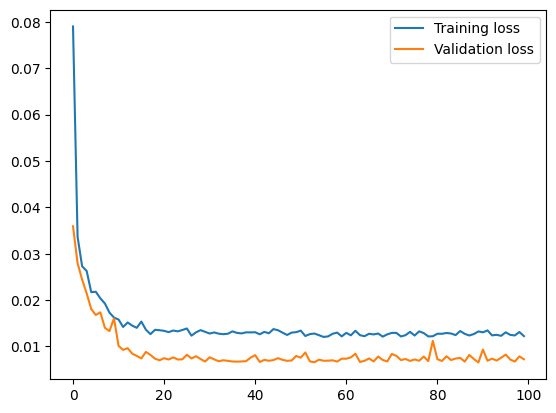

In [201]:
plt.plot(validation.history['loss'],label = 'Training loss')
plt.plot(validation.history['val_loss'],label='Validation loss')
plt.legend()

###Fazendo a previsao do modelo

In [202]:


prev = model.predict(x_test)
prev = scaler.inverse_transform(prev)
prev

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


array([[68.21503 ],
       [69.412895],
       [70.0659  ],
       ...,
       [74.77598 ],
       [76.12468 ],
       [72.374626]], dtype=float32)

In [204]:

lenght_test = len(test)
lenght_test

1429

In [205]:


days_input_steps = lenght_test - steps
days_input_steps

1414

###Transformando a previsão em array

In [206]:


input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1,-1)
input_steps

array([[ 0.09413986,  0.12781051,  0.05389934, -0.1427865 , -0.14401835,
        -0.11445388, -0.18097394, -0.15880059, -0.06435854, -0.10172474,
        -0.11856006, -0.06312668, -0.21710829, -0.24913646, -0.16208553]])

###Transformando em lista

In [207]:

list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()
list_output_steps

[0.09413986227959445,
 0.12781050642057667,
 0.05389933635500543,
 -0.14278649954170916,
 -0.14401835237613542,
 -0.1144538843499069,
 -0.18097393740892131,
 -0.15880058638924965,
 -0.06435853574990857,
 -0.10172473839416951,
 -0.11856006046466122,
 -0.06312668291548235,
 -0.21710828721875602,
 -0.249136460913837,
 -0.16208552728105333]

###Loop para prever os proximos dias úteis de Novembro

In [208]:


pred_output = []
i = 0
n_future = 21
while(i<n_future):

    if(len(list_output_steps) > steps):

      input_steps = np.array(list_output_steps[1:])
      print ("{} dia. Valores de entrada -> {}".format(i,input_steps))
      input_steps = input_steps.reshape(1,-1)
      input_steps = input_steps.reshape((1,steps,1))
      #print(input_steps)
      pred = model.predict(input_steps,verbose = 0)
      print ("{} dia. Valor previsto -> {}".format(i,pred))
      list_output_steps.extend(pred[0].tolist())
      list_output_steps = list_output_steps[1:]
      #print(list_output_steps)
      pred_output.extend(pred.tolist())
      i=i+1
    else:
      input_steps = input_steps.reshape((1, steps,1))
      pred = model.predict(input_steps,verbose=0)
      print(pred[0])
      list_output_steps.extend(pred[0].tolist())
      print(len(list_output_steps))
      pred_output.extend(pred.tolist())
      i=i+1

print(pred_output)

[-0.14692697]
16
1 dia. Valores de entrada -> [ 0.12781051  0.05389934 -0.1427865  -0.14401835 -0.11445388 -0.18097394
 -0.15880059 -0.06435854 -0.10172474 -0.11856006 -0.06312668 -0.21710829
 -0.24913646 -0.16208553 -0.14692697]
1 dia. Valor previsto -> [[-0.12906787]]
2 dia. Valores de entrada -> [ 0.05389934 -0.1427865  -0.14401835 -0.11445388 -0.18097394 -0.15880059
 -0.06435854 -0.10172474 -0.11856006 -0.06312668 -0.21710829 -0.24913646
 -0.16208553 -0.14692697 -0.12906787]
2 dia. Valor previsto -> [[-0.10911865]]
3 dia. Valores de entrada -> [-0.1427865  -0.14401835 -0.11445388 -0.18097394 -0.15880059 -0.06435854
 -0.10172474 -0.11856006 -0.06312668 -0.21710829 -0.24913646 -0.16208553
 -0.14692697 -0.12906787 -0.10911865]
3 dia. Valor previsto -> [[-0.08925166]]
4 dia. Valores de entrada -> [-0.14401835 -0.11445388 -0.18097394 -0.15880059 -0.06435854 -0.10172474
 -0.11856006 -0.06312668 -0.21710829 -0.24913646 -0.16208553 -0.14692697
 -0.12906787 -0.10911865 -0.08925166]
4 dia. V

###Transformar a saida do loop em lista

In [209]:

prev = scaler.inverse_transform(pred_output)
prev = np.array(prev).reshape(1,-1)
list_output_prev = list(prev)
list_output_prev = prev[0].tolist()
list_output_prev

[73.5791648279967,
 74.014097495188,
 74.49993199335351,
 74.98376384828721,
 75.47594413260349,
 75.97762395336608,
 76.48807207453041,
 77.00729139926688,
 77.53428985981522,
 78.0677910591641,
 78.60836002685268,
 79.15643713754109,
 79.71188258542973,
 80.27682611817949,
 80.85167055068342,
 81.43547598152442,
 82.02819051653155,
 82.62973177824473,
 83.23997529323304,
 83.85879622516924,
 84.48607191510395]

###Pegar datas de previsao do loop

In [210]:

dates = pd.to_datetime(db_sorted['Data'])
predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods=21, freq='b').tolist()
predict_dates

[Timestamp('2024-11-01 00:00:00'),
 Timestamp('2024-11-04 00:00:00'),
 Timestamp('2024-11-05 00:00:00'),
 Timestamp('2024-11-06 00:00:00'),
 Timestamp('2024-11-07 00:00:00'),
 Timestamp('2024-11-08 00:00:00'),
 Timestamp('2024-11-11 00:00:00'),
 Timestamp('2024-11-12 00:00:00'),
 Timestamp('2024-11-13 00:00:00'),
 Timestamp('2024-11-14 00:00:00'),
 Timestamp('2024-11-15 00:00:00'),
 Timestamp('2024-11-18 00:00:00'),
 Timestamp('2024-11-19 00:00:00'),
 Timestamp('2024-11-20 00:00:00'),
 Timestamp('2024-11-21 00:00:00'),
 Timestamp('2024-11-22 00:00:00'),
 Timestamp('2024-11-25 00:00:00'),
 Timestamp('2024-11-26 00:00:00'),
 Timestamp('2024-11-27 00:00:00'),
 Timestamp('2024-11-28 00:00:00'),
 Timestamp('2024-11-29 00:00:00')]

###Colocar em um array as data

In [211]:
forecast_dates = []
for i in predict_dates:
  forecast_dates.append(i.date())

In [212]:

df_forecast = pd.DataFrame({'Data' : np.array(forecast_dates), 'Valor': list_output_prev })

###Criação do Dataframe de previsão, unido as datas e as previsões

In [213]:

forecast_dates = []
for i in predict_dates:
  forecast_dates.append(i.date())

df_forecast = pd.DataFrame({'Data' : np.array(forecast_dates), 'Valor': list_output_prev })

df_forecast['Data'] = pd.to_datetime(df_forecast['Data'],format ="%Y-%m-%d")

df_forecast = df_forecast.set_index(pd.DatetimeIndex(df_forecast['Data'].values))
df_forecast.drop('Data',axis=1,inplace=True)
df_forecast['Valor'] = pd.to_numeric(df_forecast['Valor']).round(2)

In [214]:
df_forecast

,Valor
2024-11-01,73.58
2024-11-04,74.01
2024-11-05,74.50
2024-11-06,74.98
2024-11-07,75.48
2024-11-08,75.98
2024-11-11,76.49
2024-11-12,77.01
2024-11-13,77.53
2024-11-14,78.07


###Pegando o mesmo dia do dataframe de comparação separado no início

In [215]:
df_previsao = df_forecast.head(1)

##novo Dataframe com somente outubro de 2024

In [216]:
db_2024 = db
db_2024 = db_2024.reset_index()
db_2024 = db_2024.rename(columns = {'index':'Data'})
db_2024 = db_2024.tail(10)
##db_2024 = db_2024.set_index(db_2024['Data'])
##db_2024 = db_2024.drop('Data',axis=1)
db_2024['Valor'] = pd.to_numeric(db_2024['Valor'])


In [217]:
df_forecast = df_forecast.reset_index()
df_forecast = df_forecast.rename(columns = {'index':'Data'})

###Novo dataframe com somente o mês anteriro e o mês previsto

In [218]:
df_concat = pd.concat([db_2024,df_forecast])
df_concat['Valor'] = pd.to_numeric(df_concat['Valor'])
df_concat = df_concat[df_concat['Data'].dt.dayofweek < 5]

In [219]:
ultima_data = db_2024['Data'].max()

In [220]:
ultima_data

Timestamp('2024-10-31 00:00:00')

In [221]:
df_concat['Cor'] = ['red' if df_concat > ultima_data else 'blue' for df_concat in df_concat['Data']]
df_concat['Tipo'] = ['Previsão' if df_concat == 'red' else 'Fechamento' for df_concat in df_concat['Cor']]

In [222]:
df_concat

,Data,Valor,Cor,Tipo
4754,2024-10-18,72.75,blue,Fechamento
4755,2024-10-21,73.29,blue,Fechamento
4756,2024-10-22,75.59,blue,Fechamento
4757,2024-10-23,74.68,blue,Fechamento
4758,2024-10-24,74.27,blue,Fechamento
4759,2024-10-25,75.62,blue,Fechamento
4760,2024-10-28,71.87,blue,Fechamento
4761,2024-10-29,71.09,blue,Fechamento
4762,2024-10-30,73.21,blue,Fechamento
4763,2024-10-31,73.25,blue,Fechamento


In [223]:
cores = {"Fechamento": "blue", "Previsão": "red"}
df_concat['Cor'] = df_concat['Tipo'].map(cores)

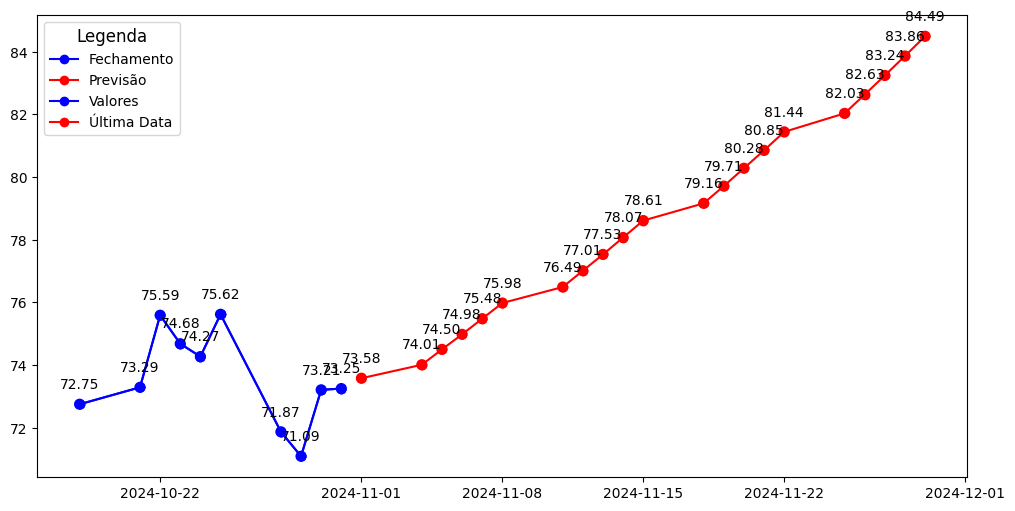

In [224]:
#plotar grafico
plt.figure(figsize=(12,6))

for categoria, grupo in df_concat.groupby('Tipo'):
    plt.plot(grupo['Data'], grupo['Valor'], label=categoria, marker='o', color=cores[categoria])

dados_fechamento = df_concat[df_concat['Cor']=='blue']
plt.plot(dados_fechamento['Data'], dados_fechamento['Valor'], label='Valores', marker='o', color='blue')

dados_mais_recente = df_concat[df_concat['Data'] =='red']
plt.plot(dados_mais_recente['Data'], dados_mais_recente['Valor'], label='Última Data', marker='o', color='red')


##plt.plot(df_concat['Data'] ,df_concat['Valor'])
plt.scatter(df_concat['Data'],df_concat['Valor'],color = df_concat['Cor'],s=50)

for i, row in df_concat.iterrows():
    plt.text(
        x=row['Data'],                # Posição no eixo X
        y=row['Valor'] + 0.5,         # Posição no eixo Y (ligeiramente acima do ponto)
        s=f"{row['Valor']:.2f}",      # Texto a ser exibido
        fontsize=10, color='black',   # Estilo do texto
        ha='center'                   # Alinhamento horizontal
    )


plt.legend(title="Legenda", fontsize=10, title_fontsize=12)
plt.show()

In [225]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [226]:
def mape(y_true, y_pred):
  return mean_absolute_percentage_error(y_true,y_pred)

##Análise de performance

In [227]:
wmape_Naive = wmape(db_comparacao['Valor'].values, df_previsao['Valor'].values)
print(f'WMAPE: {wmape_Naive:.2%}')

WMAPE: 0.07%


In [228]:
db_final = db
db_final = db_final.reset_index()
db_final = db_final.rename(columns = {'index':'Data'})

In [229]:
db_consolidado = pd.concat([db_final,df_forecast])

In [230]:
db_consolidado

,Data,Valor
0,2006-01-03,61.51
1,2006-01-04,61.25
2,2006-01-05,61.68
3,2006-01-06,62.43
4,2006-01-09,62.51
...,...,...
16,2024-11-25,82.03
17,2024-11-26,82.63
18,2024-11-27,83.24
19,2024-11-28,83.86


In [231]:
db_consolidado['Valor'] = pd.to_numeric(db_consolidado['Valor'])

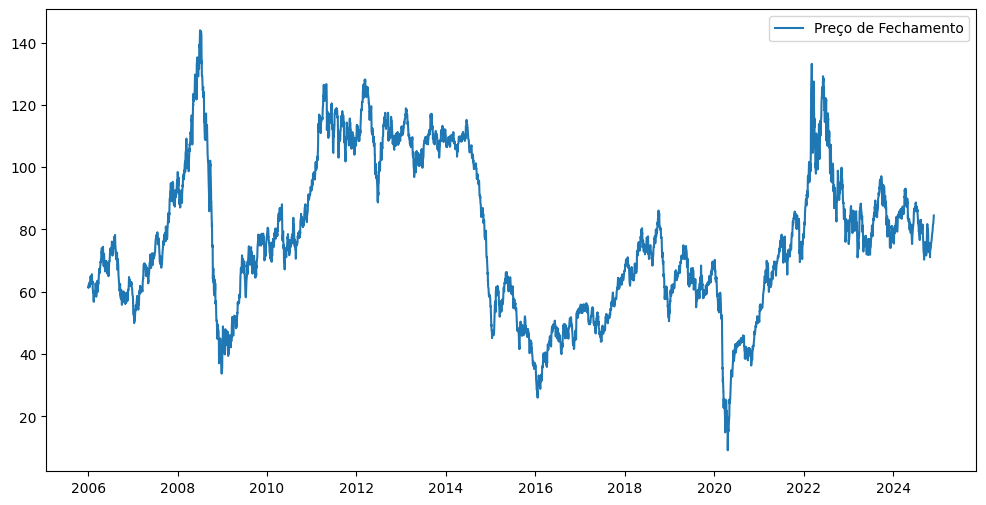

In [232]:
#plotar grafico
plt.figure(figsize=(12,6))
plt.plot(db_consolidado['Data'] ,db_consolidado['Valor'])
plt.legend(['Preço de Fechamento'])
plt.show()

In [56]:
##from google.colab import files
##db_consolidado.to_csv('base_diaria.csv',index=False)


In [57]:
##files.download('base_diaria.csv')